<a href="https://colab.research.google.com/github/Barasinghaa/Deep_learning/blob/main/BERT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.0 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
import pandas as pd

df=pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [8]:
#Balancing the data
df_spam=df[df["Category"]=="spam"]
df_spam.shape

(747, 2)

In [9]:
df_ham=df[df["Category"]=="ham"]
df_ham.shape

(4825, 2)

In [13]:
df_spam=df_spam.sample(4825,replace=True)

In [14]:
df_balanced=pd.concat([df_spam,df_ham])

In [15]:
df_balanced.shape

(9650, 2)

In [16]:
df_balanced.Category.value_counts()

spam    4825
ham     4825
Name: Category, dtype: int64

In [17]:
df_balanced["spam"]=df_balanced["Category"].apply(lambda x: 1 if x=="spam" else 0)

In [20]:
df_balanced.sample(5)

,Category,Message,spam
1225,spam,You are a winner U have been specially selecte...,1
3896,ham,Yes. Last practice,0
5348,ham,Do I? I thought I put it back in the box,0
54,spam,SMS. ac Sptv: The New Jersey Devils and the De...,1
789,spam,"5 Free Top Polyphonic Tones call 087018728737,...",1


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [22]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [25]:
def get_sentence_embedding(sentence):
  preprocess_text=bert_preprocess(sentence)
  return bert_encoder(preprocess_text)["pooled_output"]

In [26]:
get_sentence_embedding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.5132727 , -0.88845736, ..., -0.7474883 ,
        -0.75314754,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.71745336,  0.88082975]], dtype=float32)>

In [28]:
e = get_sentence_embedding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [37]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703803]], dtype=float32)

In [38]:
#Bert layers
text_input= tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")

text_preprocess= bert_preprocess(text_input)

text_encoder= bert_encoder(text_preprocess)

#NN layers
l=tf.keras.layers.Dropout(0.1,name="dropout")(text_encoder["pooled_output"])

l= tf.keras.layers.Dense(1,activation="sigmoid", name="Dense")(l)

#Final model
model= tf.keras.Model(inputs=[text_input],outputs=[l])

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [40]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [41]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
227/227 [==============================] - 89s 341ms/step - loss: 0.4501 - accuracy: 0.8213 - precision: 0.8143 - recall: 0.8325
Epoch 2/10
227/227 [==============================] - 77s 341ms/step - loss: 0.2858 - accuracy: 0.9096 - precision: 0.8995 - recall: 0.9223
Epoch 3/10
227/227 [==============================] - 78s 341ms/step - loss: 0.2375 - accuracy: 0.9208 - precision: 0.9143 - recall: 0.9287
Epoch 4/10
227/227 [==============================] - 77s 341ms/step - loss: 0.2054 - accuracy: 0.9369 - precision: 0.9334 - recall: 0.9409
Epoch 5/10
227/227 [==============================] - 77s 340ms/step - loss: 0.1876 - accuracy: 0.9399 - precision: 0.9405 - recall: 0.9392
Epoch 6/10
227/227 [==============================] - 77s 340ms/step - loss: 0.1747 - accuracy: 0.9461 - precision: 0.9478 - recall: 0.9442
Epoch 7/10
227/227 [==============================] - 77s 340ms/step - loss: 0.1626 - accuracy: 0.9505 - precision: 0.9543 - recall: 0.9464
Epoch 8/10
227/227 [

In [42]:
model.evaluate(X_test,y_test)

76/76 [==============================] - 27s 339ms/step - loss: 0.1382 - accuracy: 0.9598 - precision: 0.9703 - recall: 0.9486


[0.13815313577651978,
 0.9598010778427124,
 0.9703390002250671,
 0.9486329555511475]

In [43]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

76/76 [==============================] - 26s 335ms/step


In [44]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, ..., 1, 1, 0])

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[1171,   35],
       [  62, 1145]])

Text(50.722222222222214, 0.5, 'Truth')

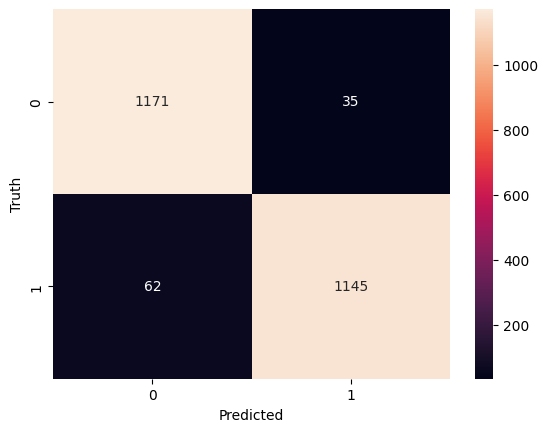

In [46]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [47]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1206
           1       0.97      0.95      0.96      1207

    accuracy                           0.96      2413
   macro avg       0.96      0.96      0.96      2413
weighted avg       0.96      0.96      0.96      2413



In [49]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',

    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 0s 47ms/step


array([[0.90167296],
       [0.97637886],
       [0.85953933],
       [0.07255027],
       [0.01263307]], dtype=float32)